In [1]:
import numpy as np

In [2]:
rng = np.random.default_rng(seed=20250306)

In [3]:
def generate_random_problem(n=64, k=5):
    props = rng.uniform(size=k)
    return rng.choice(k, size=n, p=props/props.sum())

In [4]:
import typing
import sys

import pydantic
import langchain_openai
import langchain_core
import tqdm.auto
import pandas as pd

from consol.confidence_models import AbstractConfidenceModel, SbftConfidenceModel, SprtConfidenceModel, PValueConfidenceModel, BayesianConfidenceModel, VoteConfidenceModel

class ConfidentSolverConfig(pydantic.BaseModel):
    max_trials: int

class ConfidentSolver:
    def __init__(
        self,
        confidence_model: typing.Union[str, AbstractConfidenceModel],
        max_trials=64,
    ):
        self.config = ConfidentSolverConfig(
            max_trials=max_trials,
        )
        if confidence_model == "sbft":
            self.confidence_model = SbftConfidenceModel()
        elif confidence_model == "sprt":
            self.confidence_model = SprtConfidenceModel()
        elif confidence_model == "pvalue":
            self.confidence_model = PValueConfidenceModel()
        elif confidence_model == "bayesian":
            self.confidence_model = BayesianConfidenceModel()
        elif confidence_model == "vote":
            self.confidence_model = VoteConfidenceModel()
        elif "consol.confidence_models" in str(confidence_model):
            self.confidence_model = confidence_model
        else:
            raise ValueError(f"Unknown Confidence Model: {confidence_model}")

    def invoke(self, answers, debug=False):
        max_trials = self.config.max_trials

        total_raw_outputs = []
        total_raw_outputs.append(answers[0]) 
        i = 1

        total_invoke = 0
        while True:     
            total_invoke += 1       
            first, second = self._get_top_two_answers(total_raw_outputs)
            trials = self._determine_trials(first, second, max_trials, len(total_raw_outputs))
            if trials == 0:
                break
            for j in range(trials):
                total_raw_outputs.append(answers[i])
                i += 1
        df = self._create_dataframe(total_raw_outputs)
        if debug:
            return df
        return {"target": df['answer'].mode().iloc[0], "total_invoke": total_invoke, "total_runs": len(total_raw_outputs)}

    def _get_top_two_answers(self, total_raw_outputs):
        total_ss = pd.Series(total_raw_outputs).value_counts()
        two = total_ss.sort_values(ascending=False).head(2).to_list()
        while len(two) < 2:
            two += [0]
        return two[0], two[1]

    def _determine_trials(self, first, second, max_trials, current_trials):
        for trials in range(0, max_trials + 1):
            if first + trials == 0:
                continue
            if self.confidence_model.test(first + trials, second):
                break
        if trials >= max_trials - current_trials:
            trials = max_trials - current_trials
        return trials

    def _create_dataframe(self, total_raw_outputs):
        return pd.DataFrame({
            'answer': total_raw_outputs,
        })

/Users/hyun-hwanjeong/miniforge3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def generate_random_problem(n=64, p = 0.5, q = 0.5, k=5):
    while True:
        props = rng.uniform(size=k-2) 
        props = props / props.sum() * (1-p-q)
        if max(props) < p: 
            break
    props = np.array([p, q] + props.tolist())
    return rng.choice(k, size=n, p=props/props.sum())

In [6]:

MAX_EXPR = 100
MAX_ITER = 64

records = []
for i in tqdm.tqdm(range(MAX_EXPR)):
    for p in np.arange(0.0, 1.00, 0.1):
        for q in np.arange(0.0, 1.00, 0.1):  # ensures p > q
            if p <= q: continue
            if p + q > 1: continue
            if 1-p-q < 0: continue
            if p+q < 1-p-q: continue
            
            problem = generate_random_problem(k=5, p=p, q=q)
            answer = np.bincount(problem).argmax()
            # for solver_name in ["sbft", SbftConfidenceModel(evidence_strength="strong"), "sprt", SprtConfidenceModel(p1=0.6), "pvalue","bayesian"]:
            for j, solver_name in enumerate(["sbft", SbftConfidenceModel(evidence_strength="strong"), SprtConfidenceModel(p1=0.6, alpha=0.1), SprtConfidenceModel(p1=0.6), "pvalue","bayesian"]):
                solver = ConfidentSolver(confidence_model=solver_name, max_trials=MAX_ITER)
                ret = solver.invoke(problem) 
                ret["solver"] = "sbft_strong" if "consol.confidence_models" in str(solver_name) else solver_name
                if "consol.confidence_models.Sbft" in str(solver_name):
                    ret["solver"] = "sbft_strong"
                elif "consol.confidence_models.Sprt" in str(solver_name) and j == 2:
                    ret["solver"] = "sprt_0.05"
                elif "consol.confidence_models.Sprt" in str(solver_name) and j == 3:
                    ret["solver"] = "sprt_0.10"
                else:
                    ret["solver"] = solver_name
                ret["answer"] = answer
                ret["correct"] = ret["answer"] == ret["target"]
                ret["p"] = p
                ret["q"] = q
                records.append(ret)


100%|██████████| 100/100 [00:13<00:00,  7.41it/s]


In [7]:
df_k5 = pd.DataFrame(records)

In [8]:
1-df_k5.groupby("solver")["correct"].mean().rename("error_rate")

solver
bayesian       0.014737
pvalue         0.006316
sbft           0.000000
sbft_strong    0.002105
sprt_0.05      0.000000
sprt_0.10      0.000000
Name: error_rate, dtype: float64

In [9]:
1-df_k5.groupby(["p", "q", "solver"])["correct"].mean()

p    q    solver     
0.3  0.2  bayesian       0.03
          pvalue         0.00
          sbft           0.00
          sbft_strong    0.00
          sprt_0.05      0.00
                         ... 
0.9  0.0  pvalue         0.00
          sbft           0.00
          sbft_strong    0.00
          sprt_0.05      0.00
          sprt_0.10      0.00
Name: correct, Length: 114, dtype: float64

In [10]:
df_k5.groupby("solver")["total_runs"].mean()

solver
bayesian       25.254737
pvalue         29.456316
sbft           47.870000
sbft_strong    37.068947
sprt_0.05      42.061579
sprt_0.10      48.169474
Name: total_runs, dtype: float64

In [11]:
df_k5.groupby("solver")["total_runs"].mean()

solver
bayesian       25.254737
pvalue         29.456316
sbft           47.870000
sbft_strong    37.068947
sprt_0.05      42.061579
sprt_0.10      48.169474
Name: total_runs, dtype: float64

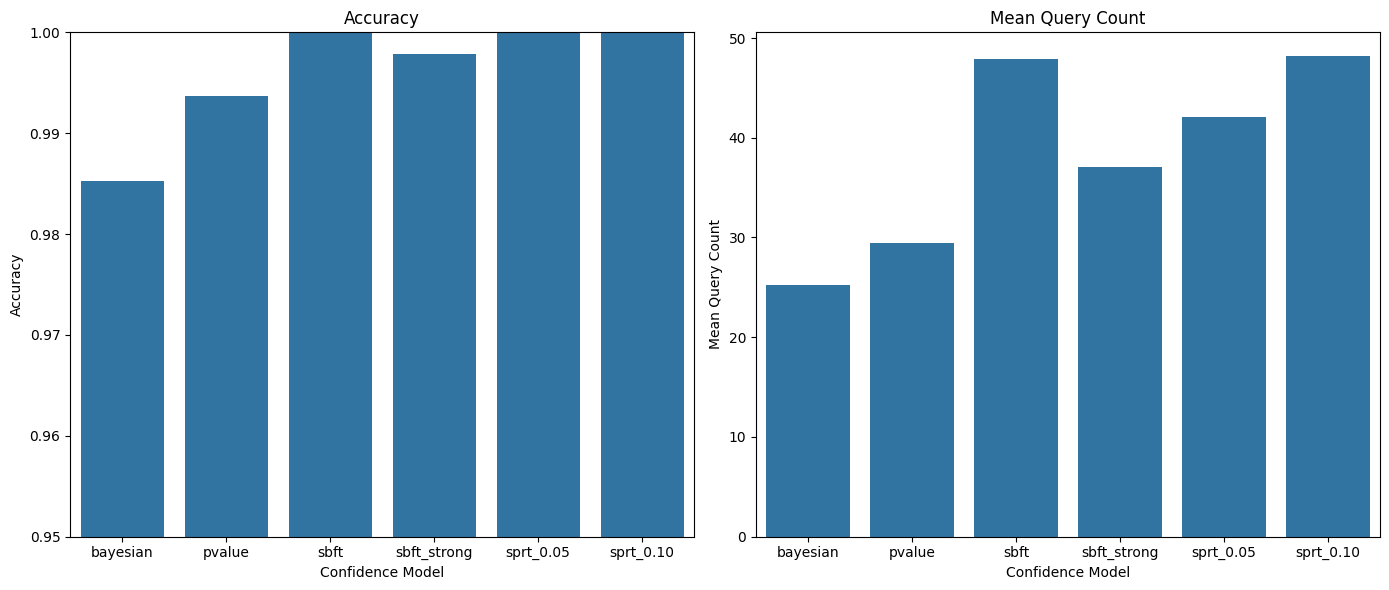

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'solver' and calculate the mean for 'correct' and 'total_runs'
mean_correct = df_k5.groupby("solver")["correct"].mean().rename("agreement")
mean_total_runs = df_k5.groupby("solver")["total_runs"].mean()

# Set up the figure for two bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for the mean of 'correct' (agreement)
sns.barplot(x=mean_correct.index, y=mean_correct.values, ax=axes[0])
axes[0].set_title("Accuracy")
axes[0].set_xlabel("Confidence Model")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0.95, 1.0)

# Bar plot for the mean of 'total_runs'
sns.barplot(x=mean_total_runs.index, y=mean_total_runs.values, ax=axes[1])
axes[1].set_title("Mean Query Count")
axes[1].set_xlabel("Confidence Model")
axes[1].set_ylabel("Mean Query Count")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

/var/folders/7y/fy_b33wn4jjcvgnn60w2l_xc0000gn/T/ipykernel_79674/3317311968.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlap with the colorbar


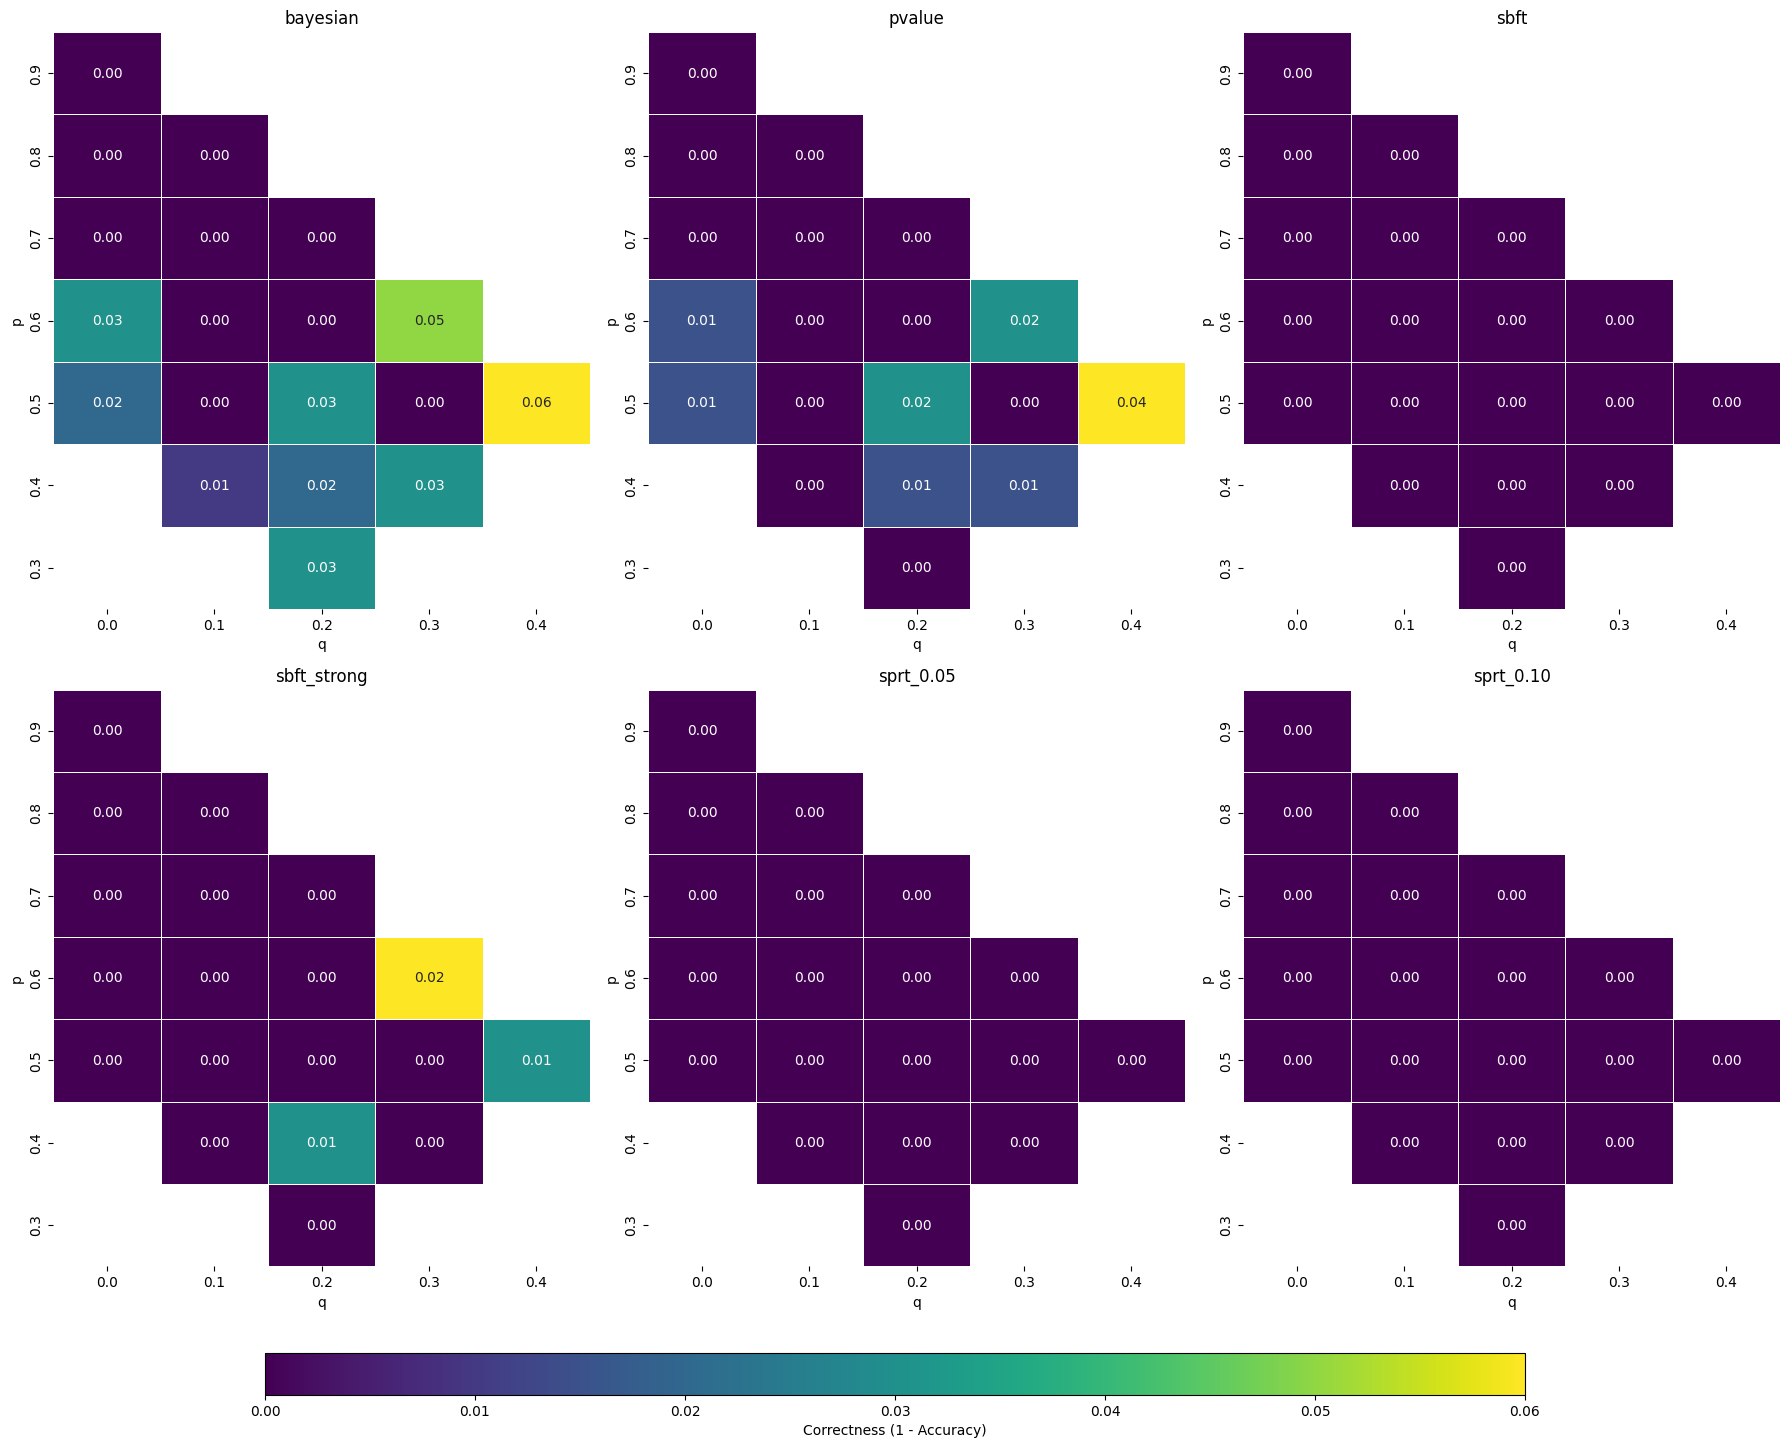

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df_k5` is the dataframe you are working with

# Grouping and calculating the mean
df_k5["p"] = df_k5["p"].round(1)
df_k5["q"] = df_k5["q"].round(1)

grouped_data = (1 - df_k5.groupby(["p", "q", "solver"])["correct"].mean()).reset_index()

# Getting the unique solvers
solvers = grouped_data['solver'].unique()

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 14))  # Create a grid of 2x3 subplots

# Flatten axes array for easy iteration
axes = axes.flatten()

# Create a list to store all the heatmap collections
heatmap_collections = []

# Create the heatmaps
for i, solver in enumerate(solvers):
    # Filter data for each solver
    solver_data = grouped_data[grouped_data['solver'] == solver]

    # Pivot the data to get 'p' as rows, 'q' as columns, and 'correct' as values
    pivot_data = solver_data.pivot_table(index="p", columns="q", values="correct")
    pivot_data = pivot_data[::-1]  # Reverse the rows for better visualization

    # Plotting the heatmap on each subplot
    sns_heatmap = sns.heatmap(pivot_data, cmap="viridis", annot=True, fmt=".2f", linewidths=.5, ax=axes[i], cbar=False)

    # Store the heatmap collections to get the color scale from
    heatmap_collections.append(sns_heatmap.collections[0])

    axes[i].set_title(f"{solver}")

# Add a unified horizontal colorbar at the bottom
cbar_ax = fig.add_axes([0.15, -0.05, 0.7, 0.03])  # Positioning the colorbar at the bottom
cbar = fig.colorbar(heatmap_collections[0], cax=cbar_ax, orientation='horizontal')  # Use the first heatmap for color scale
cbar.set_label("Correctness (1 - Accuracy)")  # Label the colorbar

# Adjust layout to make space for the colorbar
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlap with the colorbar
plt.show()